In [1]:
# setting up script
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"


import torch
from torch.utils.hooks import RemovableHandle
from typing import Dict, List
import numpy as np
from collections import defaultdict
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, BitsAndBytesConfig
import matplotlib.pyplot as plt
import seaborn as sns

class LlamaActivationLogger:
    def __init__(self, model):
        self.model = model
        self.activation_maps = defaultdict(list)
        self.hooks: List[RemovableHandle] = []
        
    def _activation_hook(self, name: str):
        def hook(module, input, output):
            if isinstance(output, torch.Tensor):
                self.activation_maps[name].append(
                    output.detach().cpu().numpy()
                )
            elif isinstance(output, tuple):
                self.activation_maps[name].append(
                    [o.detach().cpu().numpy() for o in output if isinstance(o, torch.Tensor)]
                )
        return hook
    
    def attach_hooks(self):
        self.remove_hooks()
        for name, module in self.model.named_modules():
            if any(layer_type in name for layer_type in [
                'self_attn',
                'mlp',
                'attention'
            ]):
                hook = module.register_forward_hook(
                    self._activation_hook(name)
                )
                self.hooks.append(hook)
    
    def remove_hooks(self):
        for hook in self.hooks:
            hook.remove()
        self.hooks.clear()
        
    def clear_activations(self):
        self.activation_maps.clear()
        
    def get_layer_statistics(self) -> Dict[str, Dict[str, float]]:
        stats = {}
        for layer_name, activations in self.activation_maps.items():
            layer_stats = {
                'mean': np.mean([np.mean(act) for act in activations]),
                'max': np.max([np.max(act) for act in activations]),
                'min': np.min([np.min(act) for act in activations]),
                'std': np.mean([np.std(act) for act in activations])
            }
            stats[layer_name] = layer_stats
        return stats

    def plot_activation_heatmap(self, layer_name: str, token_idx: int = 0):
        """Plot activation heatmap for a specific layer and token"""
        if layer_name not in self.activation_maps:
            raise ValueError(f"Layer {layer_name} not found in activation maps")
            
        activations = self.activation_maps[layer_name][0]  # Get first sequence
        if isinstance(activations, list):
            activations = activations[0]  # Handle tuple outputs
            
        # Select specific token's activations
        token_activations = activations[token_idx]
        
        plt.figure(figsize=(10, 6))
        sns.heatmap(token_activations.reshape(-1, token_activations.shape[-1]),
                   cmap='viridis',
                   center=0,
                   cbar_kws={'label': 'Activation Value'})
        plt.title(f'Activation Heatmap for {layer_name} (Token {token_idx})')
        plt.xlabel('Hidden Dimension')
        plt.ylabel('Attention Head')
        return plt.gcf()

    def plot_activation_distribution(self, layer_name: str):
        """Plot distribution of activation values for a layer"""
        if layer_name not in self.activation_maps:
            raise ValueError(f"Layer {layer_name} not found in activation maps")
            
        activations = self.activation_maps[layer_name][0]
        if isinstance(activations, list):
            activations = activations[0]
            
        plt.figure(figsize=(10, 6))
        sns.histplot(activations.flatten(), bins=50, kde=True)
        plt.title(f'Activation Distribution for {layer_name}')
        plt.xlabel('Activation Value')
        plt.ylabel('Count')
        return plt.gcf()

    def plot_layer_statistics(self):
        """Plot statistics across all layers"""
        stats = self.get_layer_statistics()
        
        metrics = ['mean', 'max', 'min', 'std']
        values = {metric: [] for metric in metrics}
        layers = []
        
        for layer_name, layer_stats in stats.items():
            layers.append(layer_name.split('.')[-1])  # Get last part of layer name
            for metric in metrics:
                values[metric].append(layer_stats[metric])
                
        plt.figure(figsize=(15, 8))
        x = np.arange(len(layers))
        width = 0.2
        
        for i, metric in enumerate(metrics):
            plt.bar(x + i * width, values[metric], width, label=metric)
            
        plt.xlabel('Layer')
        plt.ylabel('Value')
        plt.title('Layer Statistics Comparison')
        plt.xticks(x + width * 1.5, layers, rotation=45)
        plt.legend()
        plt.tight_layout()
        return plt.gcf()

def analyze_prompt(model, tokenizer, prompt: str, logger: LlamaActivationLogger, visualize: bool = True):
    """Analyze activations for a given prompt with optional visualization"""
    inputs = tokenizer(prompt, return_tensors="pt")
    if torch.cuda.is_available():
        inputs = {k: v.cuda() for k, v in inputs.items()}
    
    logger.clear_activations()
    logger.attach_hooks()
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    stats = logger.get_layer_statistics()
    
    if visualize:
        figures = {
            'heatmaps': {},
            'distributions': {},
            'statistics': logger.plot_layer_statistics()
        }
        
        # Generate visualizations for all attention layers
        for layer_name in stats.keys():
            if 'self_attn' in layer_name:
                figures['heatmaps'][layer_name] = logger.plot_activation_heatmap(layer_name)
                figures['distributions'][layer_name] = logger.plot_activation_distribution(layer_name)
        
        figures['statistics'] = logger.plot_layer_statistics()
        plt.close('all')
    else:
        figures = None
    
    logger.remove_hooks()
    
    return stats, figures


prompt = "Hello, how are you doing?"
base_model_name = "Llama-3.1-8B-Instruct"

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)

tokenizer = AutoTokenizer.from_pretrained(base_model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


stats, figs = analyze_prompt(base_model, tokenizer, "Your prompt", LlamaActivationLogger(base_model))


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
/mnt/faster2/dc903/CS4RP/fttenv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/tmp/ipykernel_1818950/591901305.py:97: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))
/mnt/faster2/dc903/CS4RP/fttenv/lib/python3.12/site-packages/numpy/core/_methods.py:176: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [2]:
figs['heatmaps']

{'model.layers.0.self_attn.q_proj': <Figure size 1000x600 with 2 Axes>,
 'model.layers.0.self_attn.k_proj': <Figure size 1000x600 with 2 Axes>,
 'model.layers.0.self_attn.v_proj': <Figure size 1000x600 with 2 Axes>,
 'model.layers.0.self_attn.o_proj': <Figure size 1000x600 with 2 Axes>,
 'model.layers.0.self_attn': <Figure size 1000x600 with 2 Axes>,
 'model.layers.1.self_attn.q_proj': <Figure size 1000x600 with 2 Axes>,
 'model.layers.1.self_attn.k_proj': <Figure size 1000x600 with 2 Axes>,
 'model.layers.1.self_attn.v_proj': <Figure size 1000x600 with 2 Axes>,
 'model.layers.1.self_attn.o_proj': <Figure size 1000x600 with 2 Axes>,
 'model.layers.1.self_attn': <Figure size 1000x600 with 2 Axes>,
 'model.layers.2.self_attn.q_proj': <Figure size 1000x600 with 2 Axes>,
 'model.layers.2.self_attn.k_proj': <Figure size 1000x600 with 2 Axes>,
 'model.layers.2.self_attn.v_proj': <Figure size 1000x600 with 2 Axes>,
 'model.layers.2.self_attn.o_proj': <Figure size 1000x600 with 2 Axes>,
 'mode

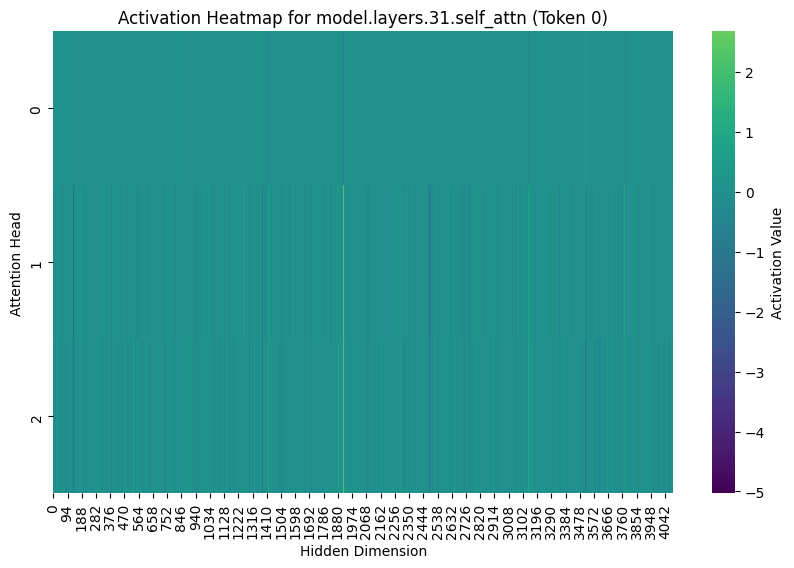

In [3]:
figs["heatmaps"]['model.layers.31.self_attn']


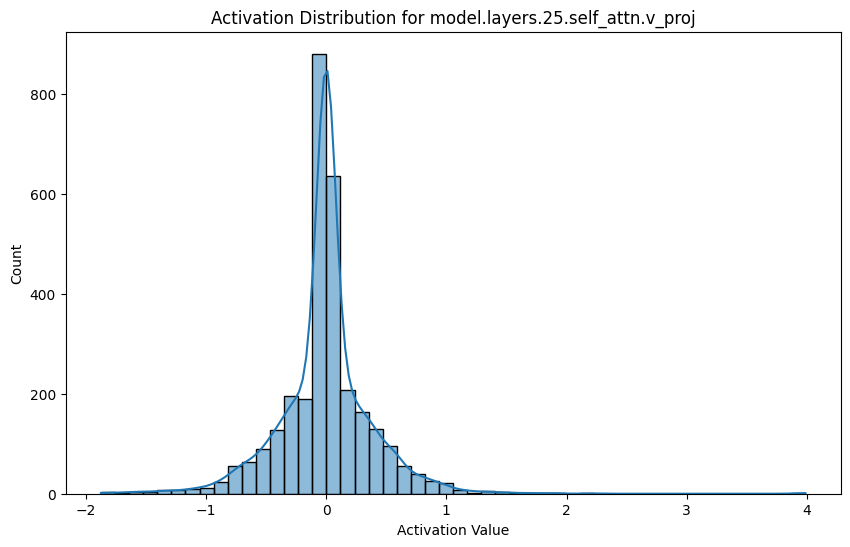

In [4]:
figs["distributions"]['model.layers.25.self_attn.v_proj']

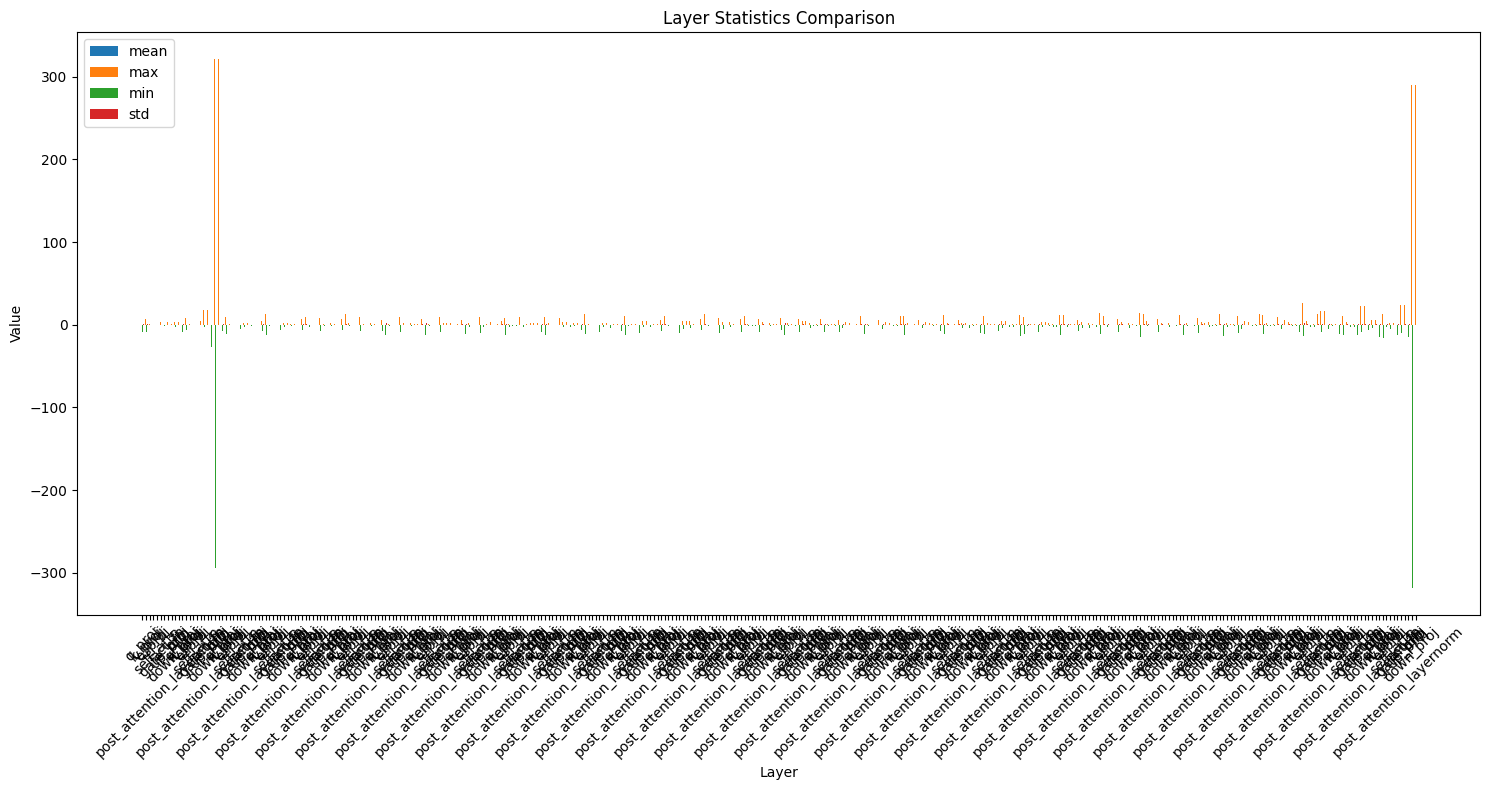

In [5]:
figs["statistics"]